Feel free to add to the imports below

In [102]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb
import graphviz
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import plot_tree
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_predict, RepeatedKFold, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.metrics import r2_score, mean_absolute_percentage_error, accuracy_score, mean_squared_error, classification_report, confusion_matrix, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn import datasets
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression, RidgeClassifier, Lasso
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from xgboost import XGBClassifier
from scipy.stats import norm, randint, uniform, median_abs_deviation
import math
import warnings
from sklearn.model_selection import cross_val_score
import keras
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import plotly.graph_objects as go
import tensorflow as tf
import tensorflow_probability as tfp
import lightgbm as lgb

warnings.filterwarnings('ignore')


In [17]:
train_df = pd.read_csv("https://raw.githubusercontent.com/enosnas/BlackScholesOptionPricePredictionProject/main/option_train.csv")
train_df.set_index(train_df.columns[0],inplace=True)
train_df.drop(train_df.columns[5], axis=1, inplace=True)

pred_df = pd.read_csv("https://raw.githubusercontent.com/enosnas/BlackScholesOptionPricePredictionProject/main/option_test_nolabel.csv")
pred_df.set_index(pred_df.columns[0], inplace=True)
pred_df['Value']=np.nan

# Start of Riley S's Code

In [18]:
#Store the feature names for graphing later
feature_names = train_df.columns[1:5]

#Split the data while retaining the column names
x, y = train_df.iloc[:, 1:5], train_df.iloc[:, 0:1]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=21)

#Create prediction data
x_predict,y_predict = pred_df.iloc[:, 0:4], pred_df.iloc[:, 4:5]

In [19]:
train_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 5000 entries, 1 to 5000
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Value   5000 non-null   float64
 1   S       5000 non-null   float64
 2   K       5000 non-null   int64  
 3   tau     5000 non-null   float64
 4   r       5000 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 234.4 KB


In [20]:
pred_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 1 to 500
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   S       500 non-null    float64
 1   K       500 non-null    int64  
 2   tau     500 non-null    float64
 3   r       500 non-null    float64
 4   Value   0 non-null      float64
dtypes: float64(4), int64(1)
memory usage: 23.4 KB


Old outlier removal method which was purely visual

In [21]:
#Filtered df for testing comparisons
train_df2 = train_df.query('S > 1300 and K > 800 and K < 1800 and r < 0.0125')

#input for the testing function model 1 unfiltered data for x and y followed by filtered
x, y = train_df.iloc[:, 1:5], train_df.iloc[:, 0:1]
x2, y2 = train_df2.iloc[:, 1:5], train_df2.iloc[:, 0:1]

Outlier Removal using modified z scores

In [22]:
#Initializing the clean_train_df

clean_train_df=train_df.copy()
#clean_train_df

In [23]:
#I could not for the life of me wrap this in a function but it works and I'm really tired of coding hahaha

#For Value
median = np.median(clean_train_df['Value'])
median_absolute_deviation = median_abs_deviation(clean_train_df['Value'])
threshold=3.5
z_scores = []

for i in clean_train_df['Value']:
      modified_z_scores = 0.6745 * (i - median) / median_absolute_deviation
      if np.abs(modified_z_scores) < threshold:
        z_scores.append(modified_z_scores)
      else:
        z_scores.append(np.nan)

clean_train_df=clean_train_df.assign(Value_z_score=z_scores)
clean_train_df=clean_train_df.dropna()

In [24]:
#For S
median = np.median(clean_train_df['S'])
median_absolute_deviation = median_abs_deviation(clean_train_df['S'])
threshold=3.5
z_scores = []

for i in clean_train_df['S']:
      modified_z_scores = 0.6745 * (i - median) / median_absolute_deviation
      if np.abs(modified_z_scores) < threshold:
        z_scores.append(modified_z_scores)
      else:
        z_scores.append(np.nan)

clean_train_df=clean_train_df.assign(S_z_score=z_scores)
clean_train_df=clean_train_df.dropna()

In [25]:
#For K
median = np.median(clean_train_df['K'])
median_absolute_deviation = median_abs_deviation(clean_train_df['K'])
threshold=3.5
z_scores = []

for i in clean_train_df['K']:
      modified_z_scores = 0.6745 * (i - median) / median_absolute_deviation
      if np.abs(modified_z_scores) < threshold:
        z_scores.append(modified_z_scores)
      else:
        z_scores.append(np.nan)

clean_train_df=clean_train_df.assign(K_z_score=z_scores)
clean_train_df=clean_train_df.dropna()

In [26]:
#For tau
median = np.median(clean_train_df['tau'])
median_absolute_deviation = median_abs_deviation(clean_train_df['tau'])
threshold=3.5
z_scores = []

for i in clean_train_df['tau']:
      modified_z_scores = 0.6745 * (i - median) / median_absolute_deviation
      if np.abs(modified_z_scores) < threshold:
        z_scores.append(modified_z_scores)
      else:
        z_scores.append(np.nan)

clean_train_df=clean_train_df.assign(tau_z_score=z_scores)
clean_train_df=clean_train_df.dropna()

In [27]:
#For r
median = np.median(clean_train_df['r'])
median_absolute_deviation = median_abs_deviation(clean_train_df['r'])
threshold=3.5
z_scores = []

for i in clean_train_df['r']:
      modified_z_scores = 0.6745 * (i - median) / median_absolute_deviation
      if np.abs(modified_z_scores) < threshold:
        z_scores.append(modified_z_scores)
      else:
        z_scores.append(np.nan)

clean_train_df=clean_train_df.assign(r_z_score=z_scores)
clean_train_df=clean_train_df.dropna()

In [28]:
clean_train_df.describe()

Value            S            K          tau            r  \
count  4704.000000  4704.000000  4704.000000  4704.000000  4704.000000   
mean    128.741264  1426.533099  1379.355867     0.302658     0.011470   
std     109.338283    56.103503   156.880978     0.204727     0.000448   
min       0.281250  1264.740000   900.000000     0.084932     0.010600   
25%      43.000000  1387.120000  1275.000000     0.139726     0.011100   
50%      98.812500  1433.475000  1400.000000     0.219178     0.011400   
75%     188.875000  1469.440000  1475.000000     0.428082     0.011700   
max     466.000000  1527.460000  1900.000000     0.857534     0.012900   

       Value_z_score    S_z_score    K_z_score  tau_z_score    r_z_score  
count    4704.000000  4704.000000  4704.000000  4704.000000  4704.000000  
mean        0.228171    -0.131768    -0.139245     0.390444     0.157584  
std         1.056382     0.949368     1.058162     1.145504     1.007547  
min        -1.012958    -2.869586    -3.372500    -0.827795    -1.798667  
25%        -0.600226    -0.798705    -0.843125    -0.521205    -0.674500  
50%        -0.060989    -0.014299     0.000000    -0.076648     0.000000  
75%         0.809158     0.594291     0.505875     1.092230     0.674500  
max         3.486628     1.576090     3.372500     3.495136     3.372500

In [29]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5000 entries, 1 to 5000
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Value   5000 non-null   float64
 1   S       5000 non-null   float64
 2   K       5000 non-null   int64  
 3   tau     5000 non-null   float64
 4   r       5000 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 234.4 KB


In [30]:
train_df.describe()

Value            S            K          tau            r
count  5000.000000  5000.000000  5000.000000  5000.000000  5000.000000
mean    140.316869  1426.643916  1370.244000     0.327615     0.011468
std     125.155000    56.051523   172.679107     0.231184     0.000448
min       0.281250  1264.740000   750.000000     0.084932     0.010600
25%      45.750000  1387.670000  1275.000000     0.142466     0.011100
50%     105.125000  1434.320000  1400.000000     0.238356     0.011400
75%     200.406250  1469.440000  1475.000000     0.463014     0.011700
max     685.500000  1527.460000  1995.000000     0.989041     0.012900

In [31]:
#Filtered training data set to account for possible outliers using z score analysis

#Split the data while retaining the column names
x3, y3 = clean_train_df.iloc[:, 1:5], clean_train_df.iloc[:, 0:1]

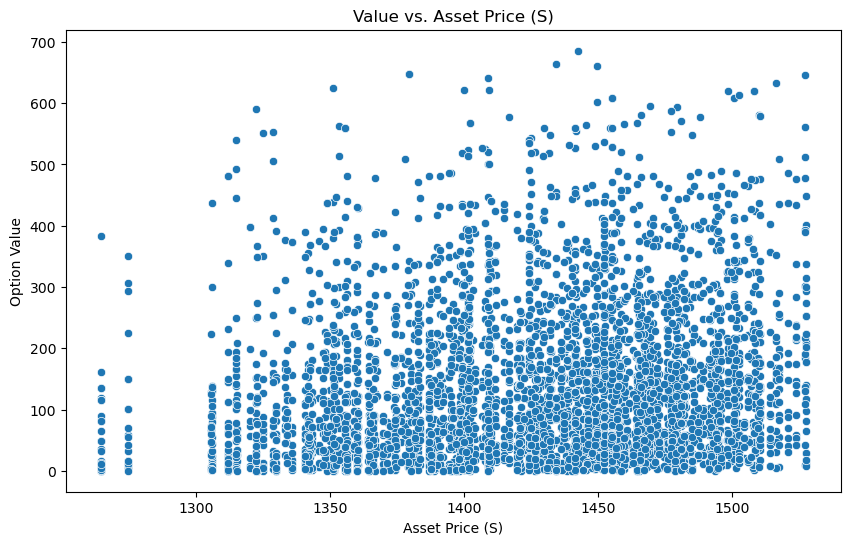

In [32]:
# Scatter plot of Value vs. S in unfiltered data
plt.figure(figsize=(10, 6))
sns.scatterplot(x='S', y='Value', data=train_df)
plt.xlabel('Asset Price (S)')
plt.ylabel('Option Value')
plt.title('Value vs. Asset Price (S)')
plt.show()

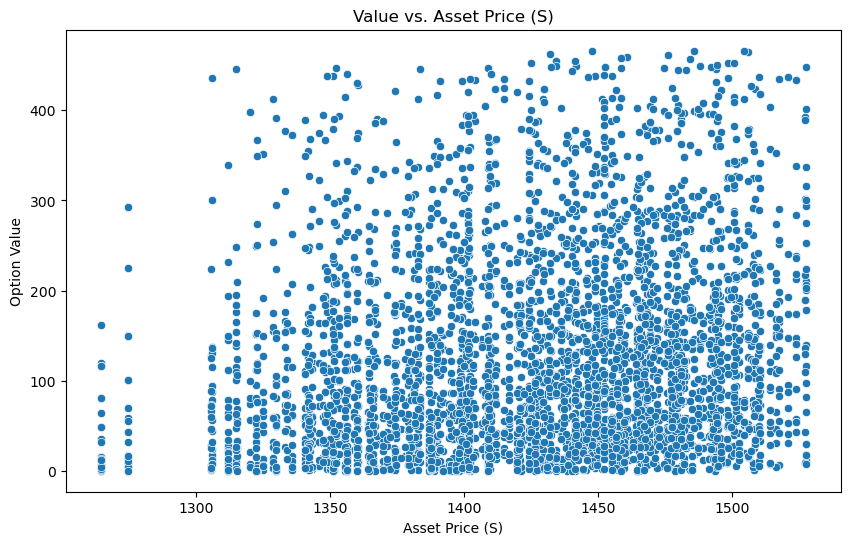

In [33]:
# Scatter plot of Value vs. S in filtered data
plt.figure(figsize=(10, 6))
sns.scatterplot(x='S', y='Value', data=clean_train_df)
plt.xlabel('Asset Price (S)')
plt.ylabel('Option Value')
plt.title('Value vs. Asset Price (S)')
plt.show()

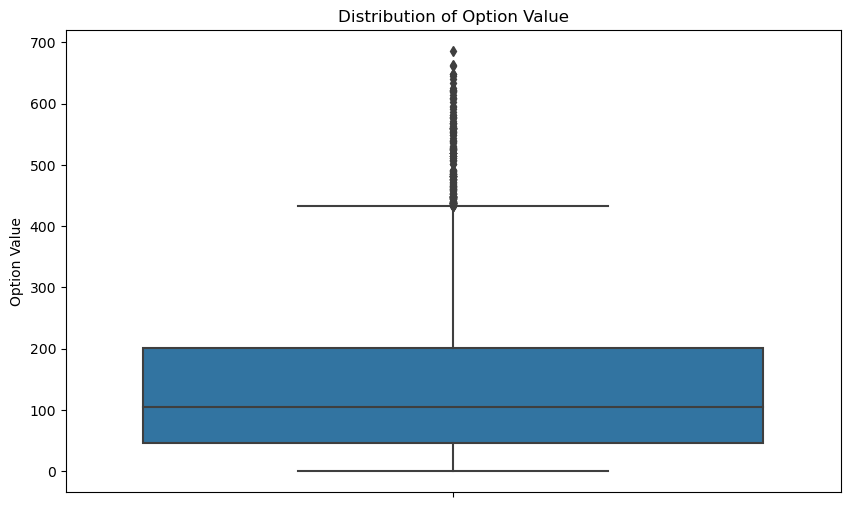

In [34]:
# Box plot of Value in unfiltered data
plt.figure(figsize=(10, 6))
sns.boxplot(y='Value', data=train_df)
plt.ylabel('Option Value')
plt.title('Distribution of Option Value')
plt.show()

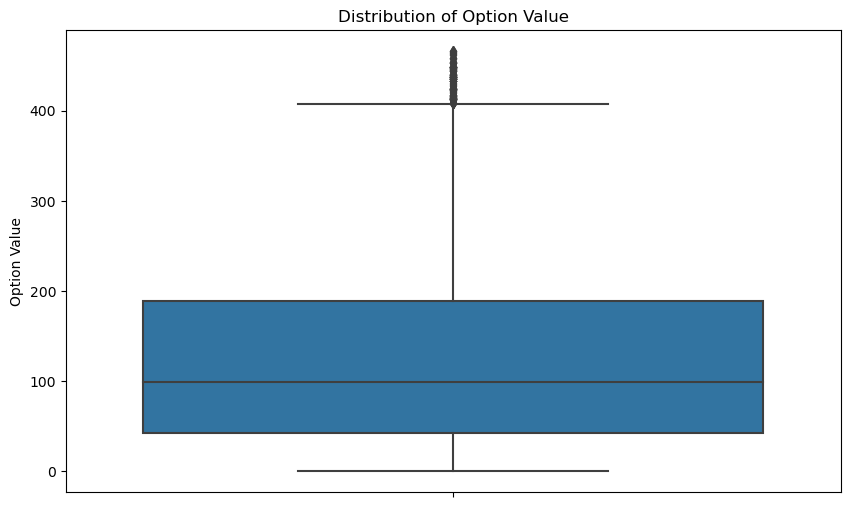

In [35]:
# Box plot of Value in filtered data
plt.figure(figsize=(10, 6))
sns.boxplot(y='Value', data=clean_train_df)
plt.ylabel('Option Value')
plt.title('Distribution of Option Value')
plt.show()

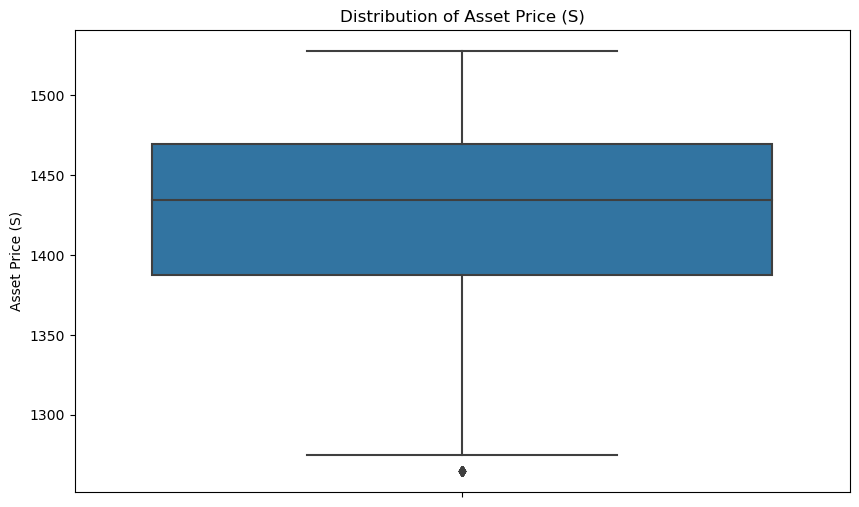

In [36]:
# Box plot of S in unfiltered data
plt.figure(figsize=(10, 6))
sns.boxplot(y='S', data=train_df)
plt.ylabel('Asset Price (S)')
plt.title('Distribution of Asset Price (S)')
plt.show()

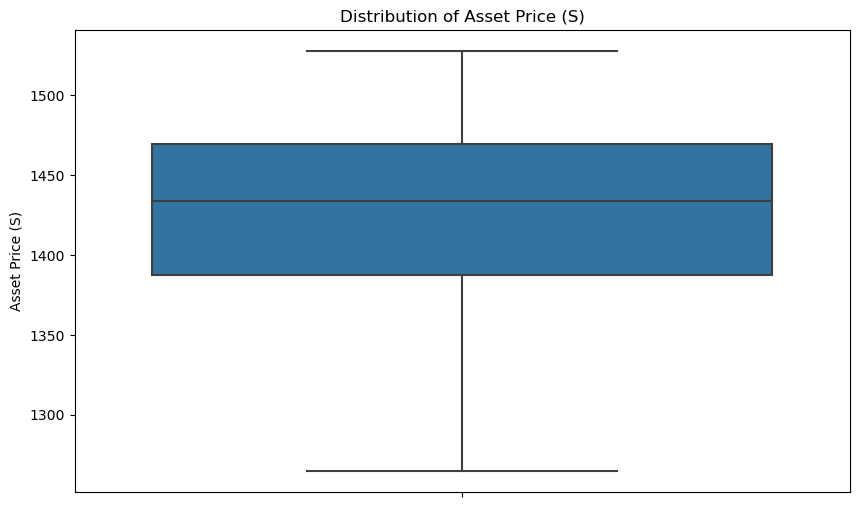

In [37]:
# Box plot of S in filtered data
plt.figure(figsize=(10, 6))
sns.boxplot(y='S', data=clean_train_df)
plt.ylabel('Asset Price (S)')
plt.title('Distribution of Asset Price (S)')
plt.show()

### End of Riley S data exploration code

# Start of Dream exploration code

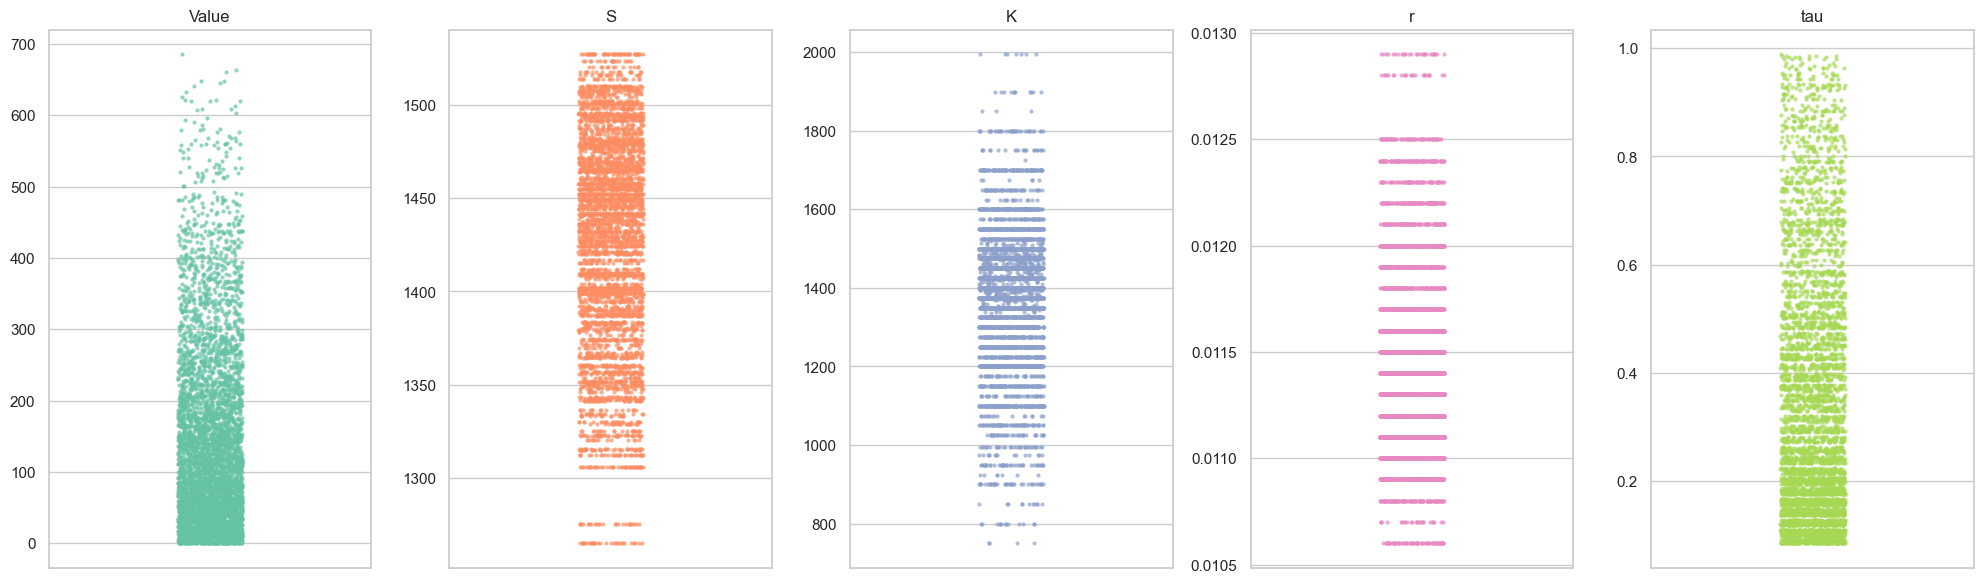

In [38]:
# Suppress FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Preprocess the data to convert infinite values to NaN
train_df = train_df.replace([np.inf, -np.inf], np.nan)

# Drop any rows that now contain NaN values
train_df = train_df.dropna()

# Set the style and color palette
sns.set(style="whitegrid")
colors = sns.color_palette("Set2")

# Create a figure with subplots
fig, axs = plt.subplots(1, 5, figsize=(20, 6))

# Plot strip plots with jitter for each feature
features = ['Value', 'S', 'K', 'r', 'tau']

for i, feature in enumerate(features):
    ax = axs[i]
    sns.stripplot(y=feature, data=train_df, ax=ax, color=colors[i], jitter=True, size=3, alpha=0.7)
    ax.set_title(feature)
    ax.set_ylabel("")
    ax.set_xlabel("")

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()


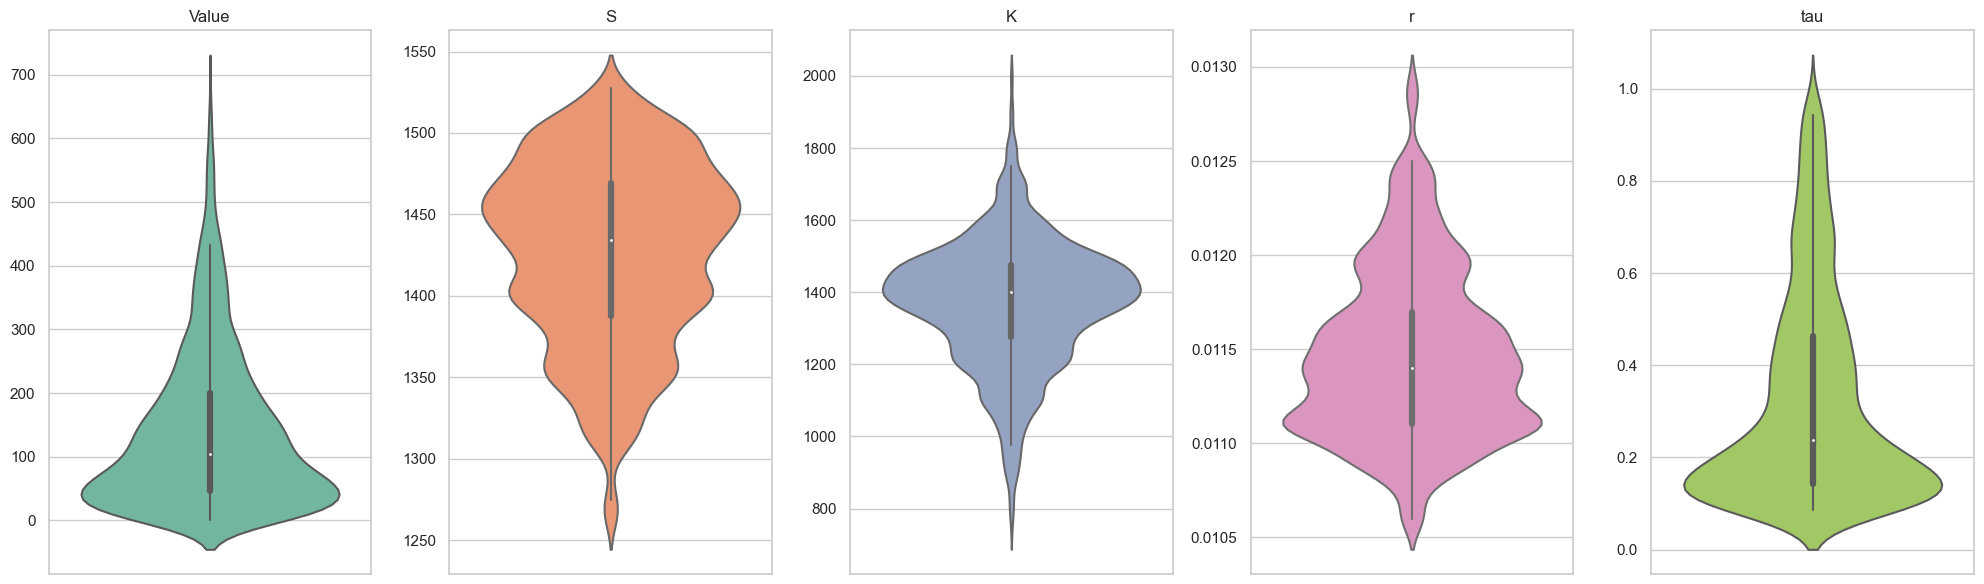

In [39]:
# Set the aesthetic style of the plots
sns.set(style="whitegrid")
colors = sns.color_palette("Set2")

# Create a figure with subplots for violin plots
fig, axs = plt.subplots(1, 5, figsize=(20, 6))

# Define the features for which you want to create violin plots
features = ['Value', 'S', 'K', 'r', 'tau']

# Plot violin plots for each feature with different colors
for i, feature in enumerate(features):
    sns.violinplot(y=feature, data=train_df, ax=axs[i], color=colors[i])
    axs[i].set_title(feature)
    axs[i].set_ylabel('')  # Remove y-axis label for cleaner look
    axs[i].set_xlabel('')  # Remove x-axis label for cleaner look

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

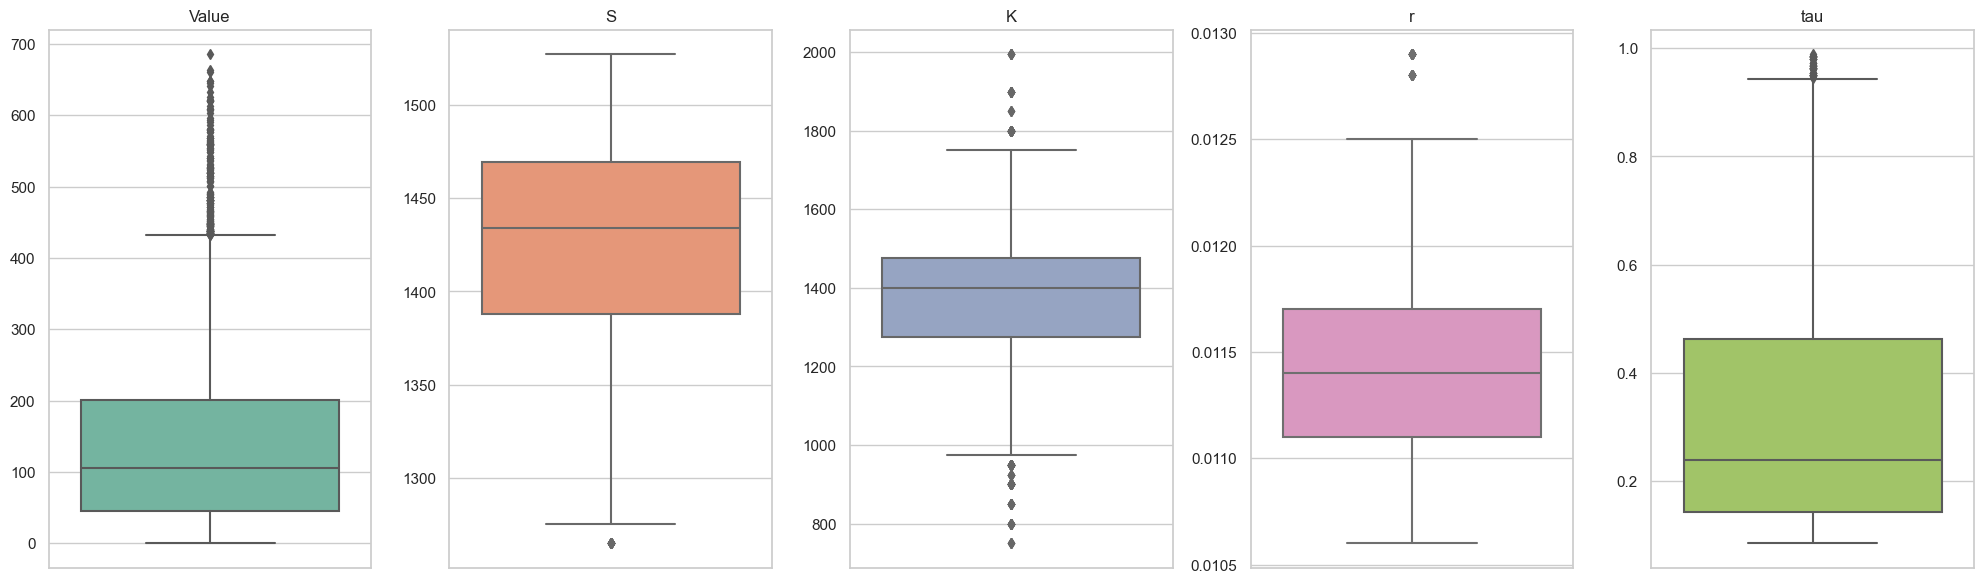

In [40]:
# Set the style and color palette
sns.set(style="whitegrid")
colors = sns.color_palette("Set2")

# Create a figure with subplots for box plots
fig1, axs1 = plt.subplots(1, 5, figsize=(20, 6))

# Plot box plots for each feature with different colors
features = ['Value', 'S', 'K', 'r', 'tau']

for i, feature in enumerate(features):
    ax = axs1[i]
    sns.boxplot(y=feature, data=train_df, ax=ax, color=colors[i], saturation=0.7)
    ax.set_title(feature)
    ax.set_ylabel("")
    ax.set_xlabel("")

# Adjust the layout and display the box plots
plt.tight_layout()
plt.show()

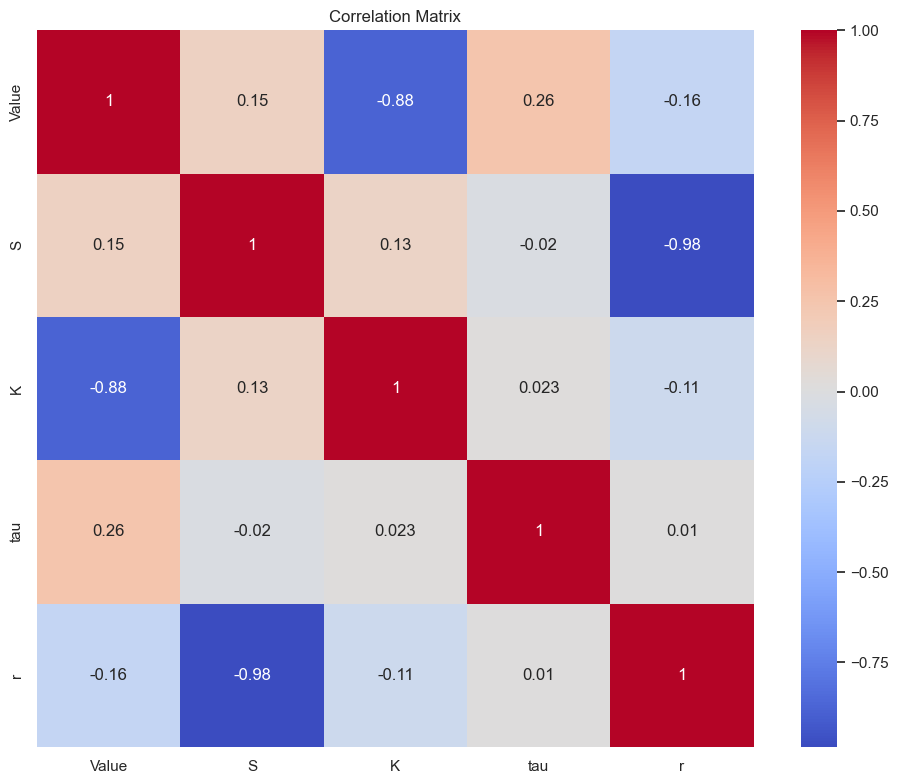

In [41]:
# Calculate the correlation matrix
corr_matrix = train_df.corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', square=True)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

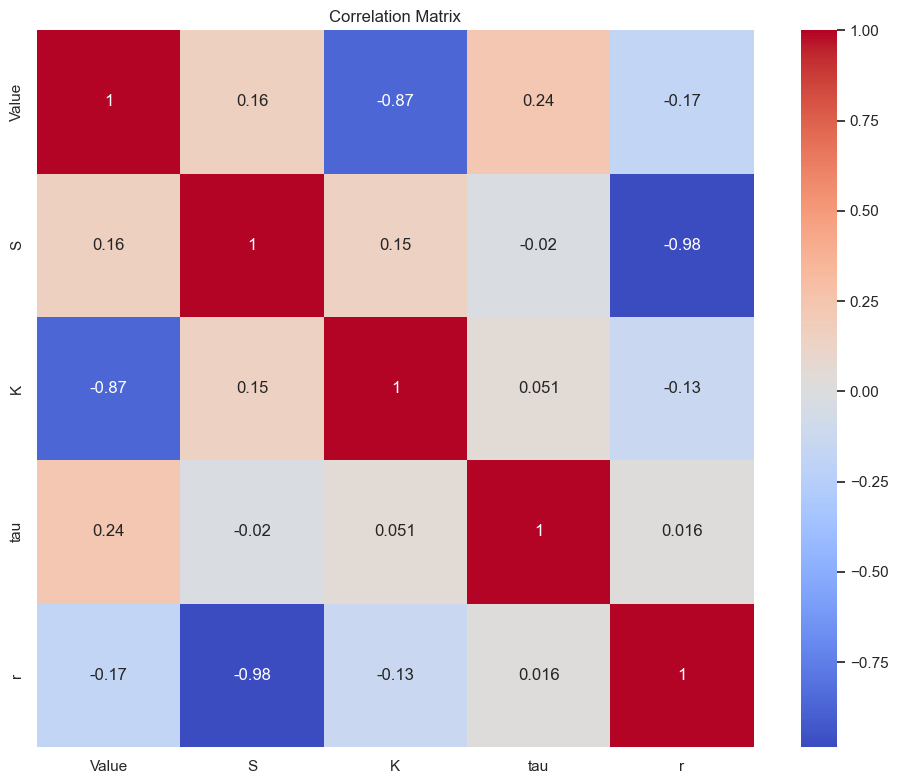

In [42]:
# Select the first five columns
first_five_columns = clean_train_df.iloc[:, :5]

# Calculate the correlation matrix for the first five columns
corr_matrix = first_five_columns.corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', square=True)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()


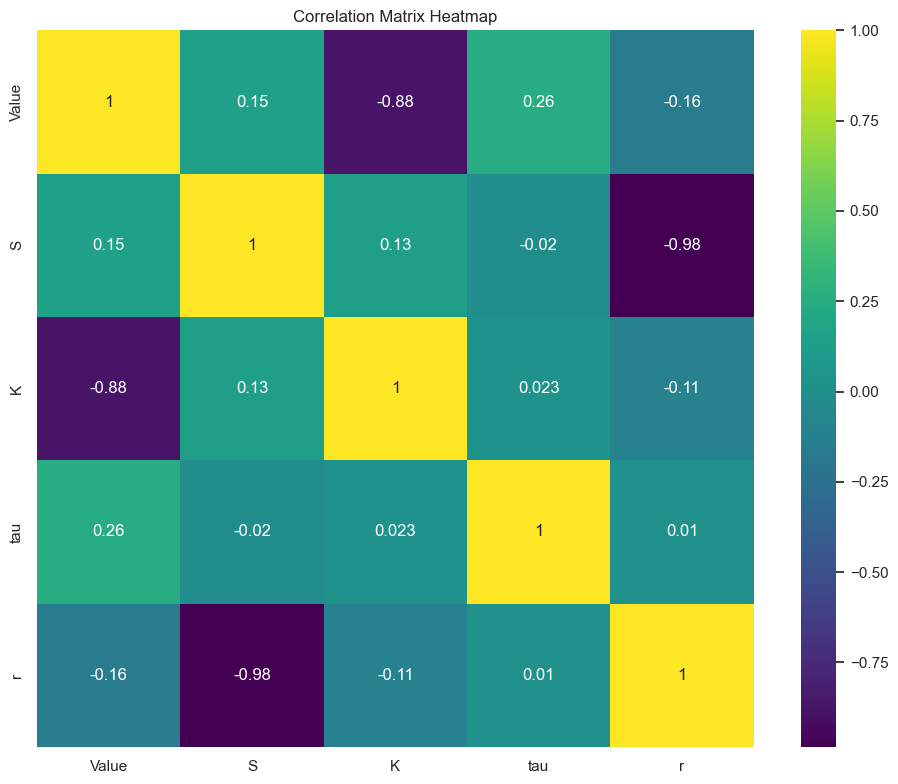

In [43]:
corr_matrix1=train_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix1, annot=True, cmap='viridis', square=True)
plt.title('Correlation Matrix Heatmap')
plt.tight_layout()
plt.show()


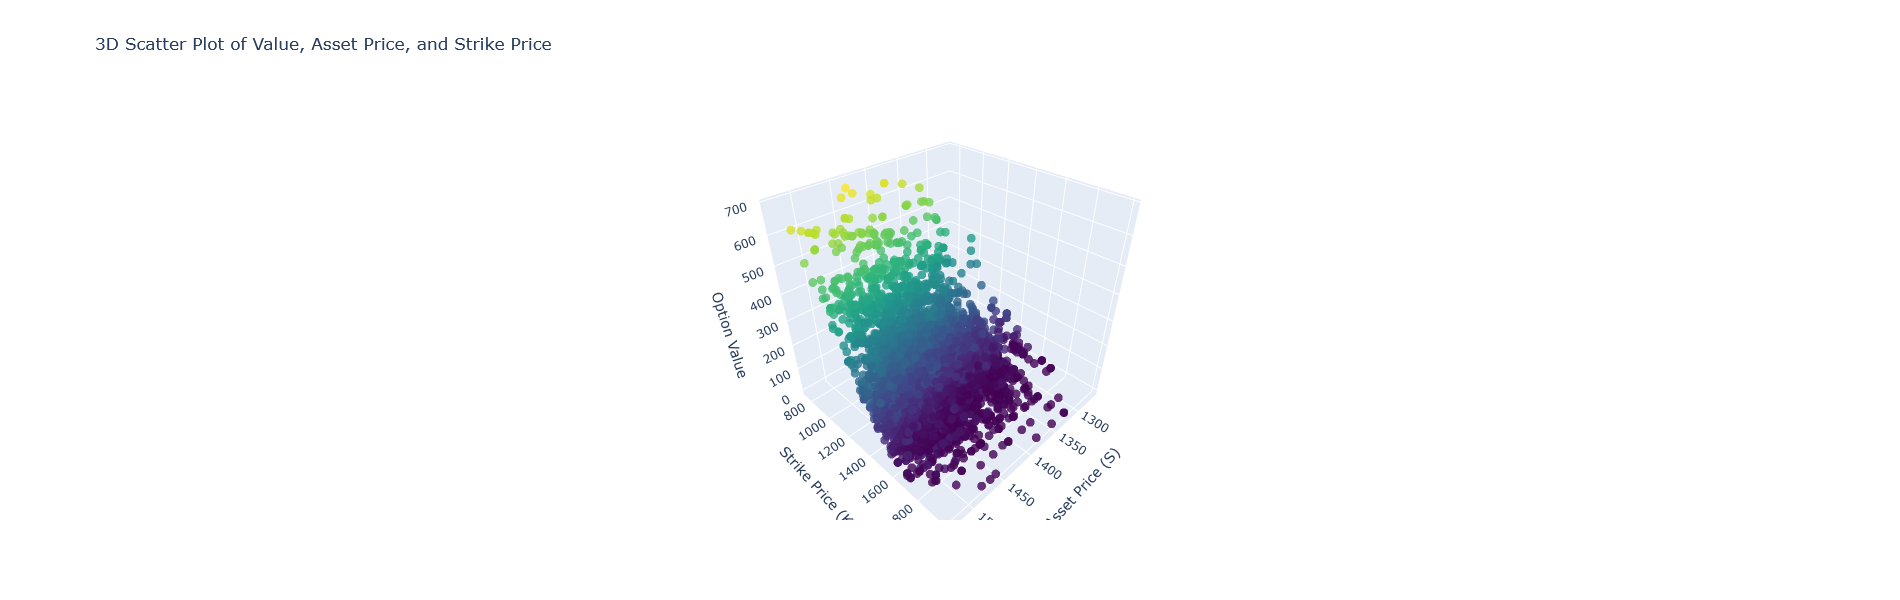

In [44]:
# Create the 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=train_df['S'],
    y=train_df['K'],
    z=train_df['Value'],
    mode='markers',
    marker=dict(
        size=5,
        color=train_df['Value'],
        colorscale='Viridis',
        opacity=0.8
    ),
    text=train_df.index,
    hoverinfo='text+x+y+z'
)])

# Customize the layout
fig.update_layout(
    title='3D Scatter Plot of Value, Asset Price, and Strike Price',
    scene=dict(
        xaxis_title='Asset Price (S)',
        yaxis_title='Strike Price (K)',
        zaxis_title='Option Value'
    ),
    width=800,
    height=600
)

# Display the plot
fig.show()

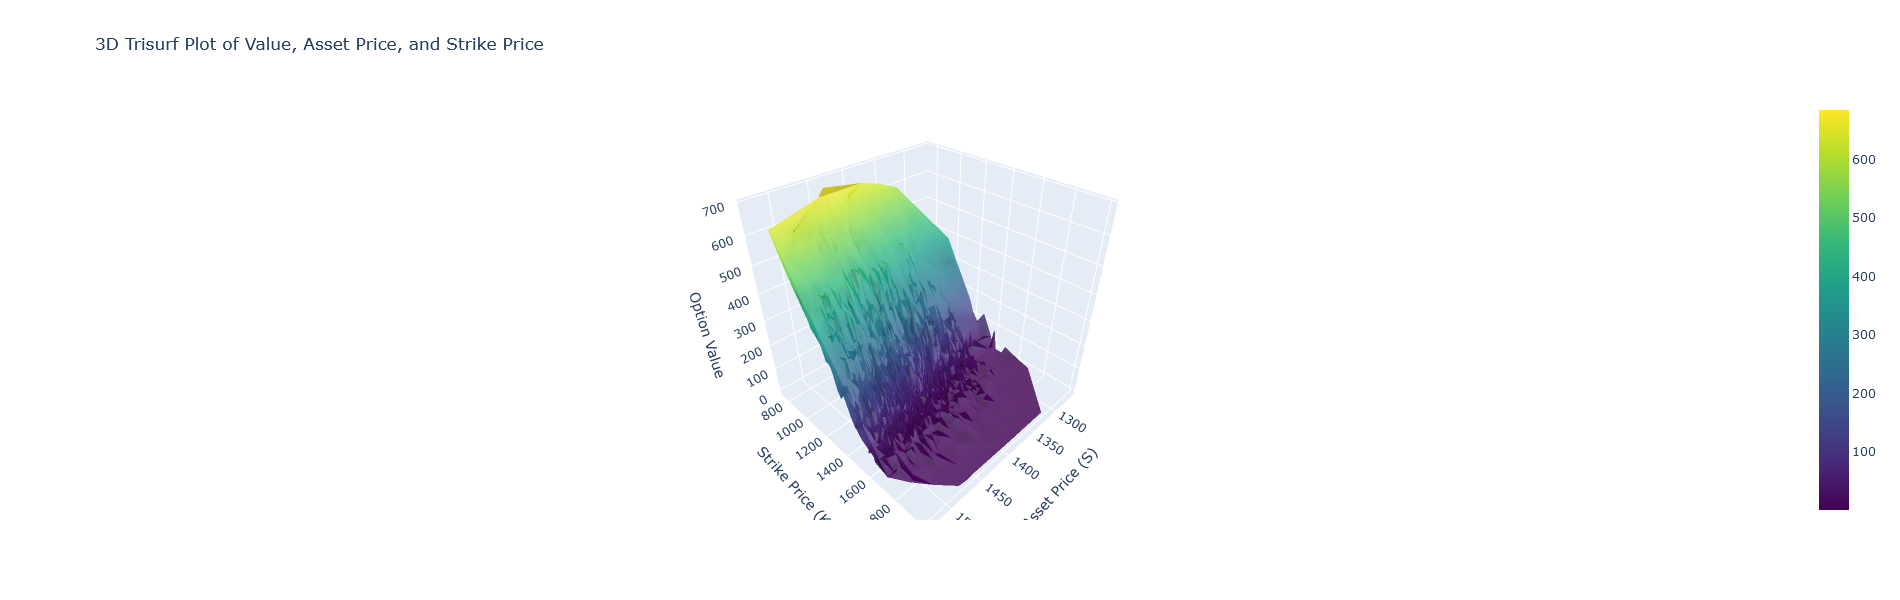

In [45]:
# Create the 3D trisurf plot
fig = go.Figure(data=[go.Mesh3d(
    x=train_df['S'],
    y=train_df['K'],
    z=train_df['Value'],
    colorscale='Viridis',
    intensity=train_df['Value'],
    opacity=0.8
)])

# Customize the layout
fig.update_layout(
    title='3D Trisurf Plot of Value, Asset Price, and Strike Price',
    scene=dict(
        xaxis_title='Asset Price (S)',
        yaxis_title='Strike Price (K)',
        zaxis_title='Option Value'
    ),
    width=800,
    height=600
)

# Display the plot
fig.show()

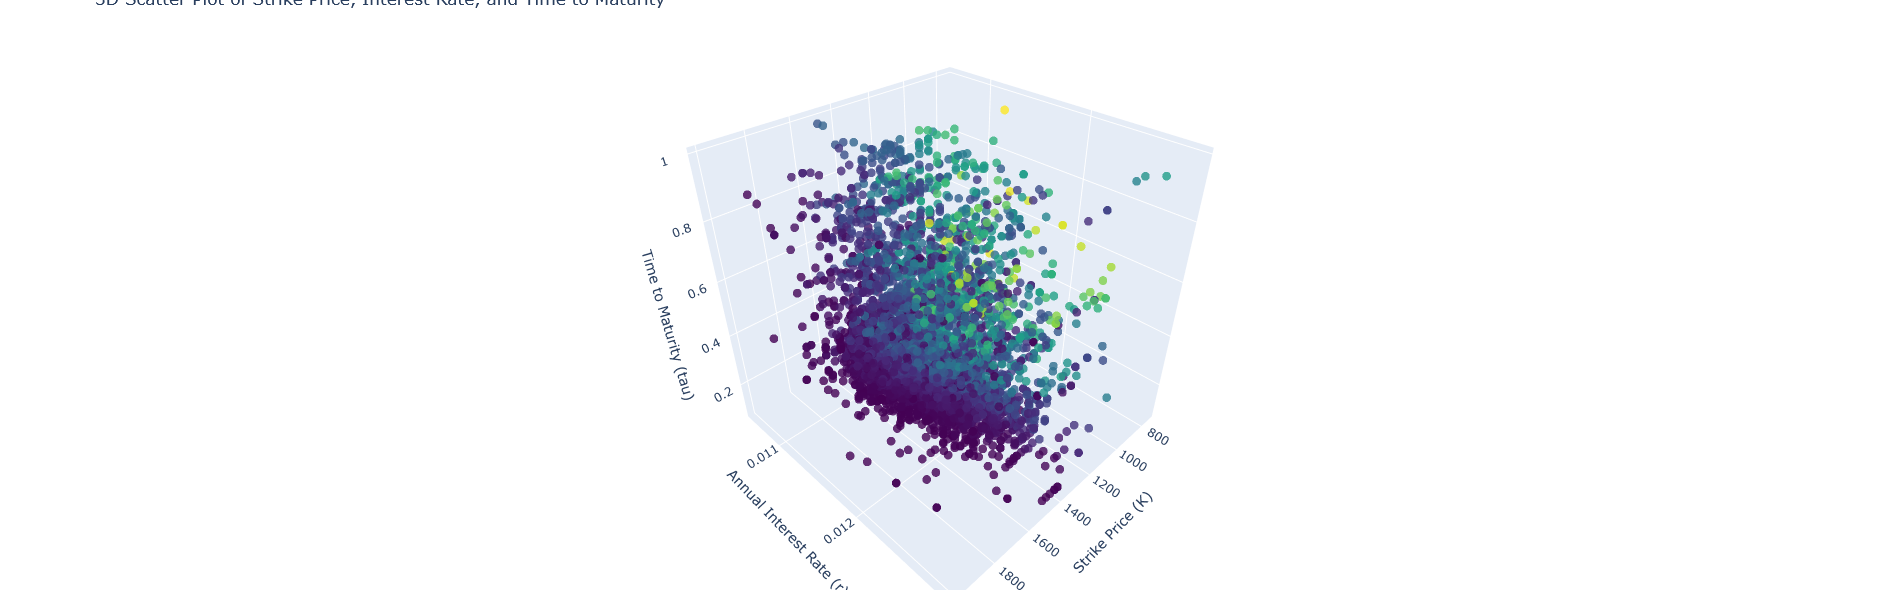

In [46]:
# Create the 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=train_df['K'],
    y=train_df['r'],
    z=train_df['tau'],
    mode='markers',
    marker=dict(
        size=5,
        color=train_df['Value'],
        colorscale='Viridis',
        opacity=0.8
    ),
    text=train_df.index,
    hoverinfo='text+x+y+z'
)])

# Customize the layout
fig.update_layout(
    title='3D Scatter Plot of Strike Price, Interest Rate, and Time to Maturity',
    scene=dict(
        xaxis_title='Strike Price (K)',
        yaxis_title='Annual Interest Rate (r)',
        zaxis_title='Time to Maturity (tau)'
    ),
    margin=dict(l=10, r=10, b=10, t=10),
    width=800,
    height=600
)

# Display the plot
fig.show()

# Start of Riley S model creation code

This is the basic model I created without running any randomizedsearchcv to optimize the parameters

In [47]:
#booster indicates what type of algorithm to use, we are gonna use gradient boosted trees
#n_estimators is the amount of different decision trees it will go through to create the best model
#early_stopping_rounds tells the model to stop after a specified amount of rounds with no improvement
#objective tells the model what to try and minimize, chose squared error as it is standard for regression
#eval metric tells the model what to output in terms of performance when running, chose mape
#max depth changes amount of leaves in the decision tree, more is less conservative but helps fitting
#reg lambda is L2 lasso normalization, handles possible outliers better than L1 which is why I chose it
#learning_rate adjusts how quickly the model fits to the data, a lower learning rate is used to stop the model from instantly overfitting data by multiplying itself with the residuals of predictions and thus reducing

reg = xgb.XGBRegressor(
    base_score=0.5,
    booster='gbtree',
    n_estimators=5000,
    early_stopping_rounds=50,
    objective='reg:squarederror',
    eval_metric = 'mape',
    max_depth=5,
    reg_lambda=500,
    learning_rate=0.005)
#verbose changes how often it shows model results
reg.fit(x_train, y_train,
        eval_set=[(x_train, y_train), (x_test, y_test)],
        verbose=1000)

#calculate R^2 score
y_pred = reg.predict(x_test)
r2_test = r2_score(y_test, y_pred)
print("Out-of-Sample R^2 Score:", r2_test)

[0]	validation_0-mape:0.96873	validation_1-mape:0.97008
[1000]	validation_0-mape:0.29095	validation_1-mape:0.34110
[1416]	validation_0-mape:0.27368	validation_1-mape:0.32482
Out-of-Sample R^2 Score: 0.9547826105756614


Using inspiration from Dream I added some optimizations to the model using randomsearchcv

In [48]:
#Using randomizedsearchcv to check parameters for best possible

# Define a parameter grid to search
param_grid = {
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 5, 10],
    'gamma': [0.5, 1, 1.5, 2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'n_estimators': [100, 500, 1000,5000],
    'learning_rate': [0.005,0.01, 0.05, 0.1],
    'base_score':[0,0.3,0.5,0.7],
    'reg_lambda':[300,500,700]
}

# Initialize RandomizedSearchCV without early_stopping_rounds
random_search = RandomizedSearchCV(
    estimator=xgb.XGBRegressor(objective='reg:squarederror'),
    param_distributions=param_grid, n_iter=10, scoring='neg_mean_squared_error', cv=5, verbose=1
)

# Fit the random search to the data
random_search.fit(x_train, y_train)

# Extract the best estimator
best_xgb = random_search.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [49]:
#lists out the best parameters found in the search
# Iterate through the parameters of the best estimator
for param, value in best_xgb.get_params().items():
    # Check if the parameter exists in the param_grid
    if param in param_grid:
        print(f"{param}: {value}")

base_score: 0
colsample_bytree: 0.6
gamma: 1
learning_rate: 0.05
max_depth: 5
min_child_weight: 10
n_estimators: 5000
reg_lambda: 700
subsample: 1.0


Optimized model

In [50]:
#gamma is the minimum loss required to partition the leaf node on a tree
#subsample allows xgboost to split the data even more before making trees

reg3 = xgb.XGBRegressor(
    base_score=0.5,
    booster='gbtree',
    n_estimators=5000,
    early_stopping_rounds=None,
    objective='reg:squarederror',
    eval_metric = 'mape',
    max_depth=7,
    reg_lambda=500,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma =2)
#verbose changes how often it shows model results
reg3.fit(x_train, y_train,
        eval_set=[(x_train, y_train), (x_test, y_test)],
        verbose=1000)

# Calculate R^2 score
y_pred = reg3.predict(x_test)
r2_test = r2_score(y_test, y_pred)
print("Out-of-Sample R^2 Score:", r2_test)

[0]	validation_0-mape:1.19780	validation_1-mape:1.25186
[1000]	validation_0-mape:0.19857	validation_1-mape:0.25428
[2000]	validation_0-mape:0.13825	validation_1-mape:0.21319
[3000]	validation_0-mape:0.11423	validation_1-mape:0.18569
[4000]	validation_0-mape:0.10283	validation_1-mape:0.17361
[4999]	validation_0-mape:0.09561	validation_1-mape:0.16569
Out-of-Sample R^2 Score: 0.998036848904556


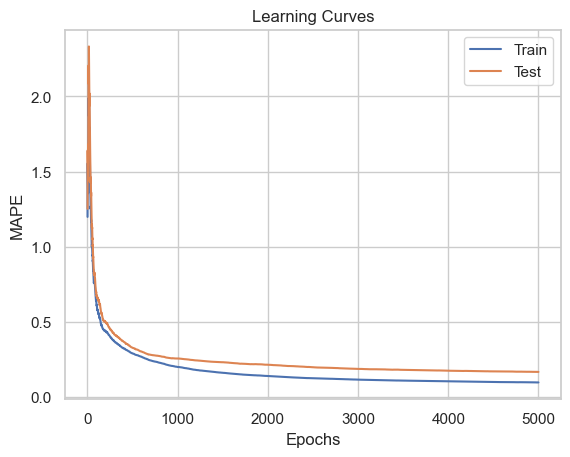

In [51]:
#extract evaluation results
results = reg3.evals_result()

#plot the learning curves
train_errors = results['validation_0']['mape']
test_errors = results['validation_1']['mape']
epochs = range(1, len(train_errors) + 1)

plt.plot(epochs, train_errors, label='Train')
plt.plot(epochs, test_errors, label='Test')
plt.xlabel('Epochs')
plt.ylabel('MAPE')
plt.title('Learning Curves')
plt.legend()
plt.show()


ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

<Figure size 4500x3000 with 0 Axes>

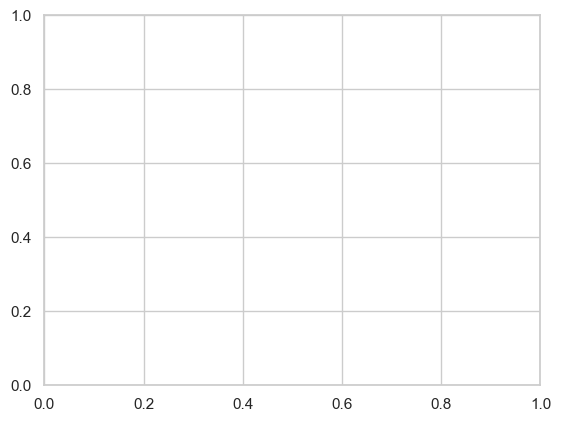

In [100]:
#graph of the decision tree built by the model, hard to get it to display well haha
plt.figure(figsize=(30, 20), dpi=150)
plot_tree(reg, num_trees=1, rankdir='LR')
plt.show()

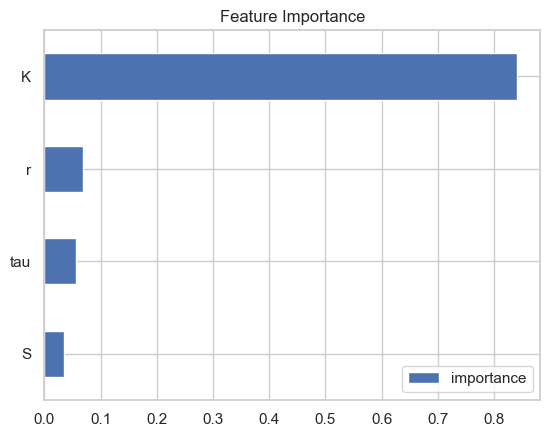

In [54]:
#create a dataframe that shows the importance of the features in the model
fi = pd.DataFrame(data=reg3.feature_importances_,
             index=reg3.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

In [55]:
#predictions for the 'testing_df' set that we are asked to submit, predictions stored in 'Value'
pred_df['Value'] = reg3.predict(x_predict)
pred_df.head()

S     K       tau       r       Value
Unnamed: 0                                             
1           1409.28  1325  0.126027  0.0115  103.434532
2           1505.97  1100  0.315068  0.0110  423.238678
3           1409.57  1450  0.197260  0.0116   49.046558
4           1407.81  1250  0.101370  0.0116  170.271118
5           1494.50  1300  0.194521  0.0110  212.862778

Function for testing non-filtered and filtered dataset according to visual outliers over multiple folds and ability to change train/test split as well as names for convenience

In [56]:
# Define evaluation function
def evaluate_model(model1, x1, y1, model2, x2, y2, num_splits=5,test_percent=0.5,m1_name='Model 1',m2_name='Model 2'):
    """
    Take a specified model and compare it over the chosen training data with differing x variable a y target values.
    In this case I made it to test the outlier included training data with x1 y1 and outlier removed x2 y2 data.

    Parameters:
    - model 1/2: Ideally keep this as the same model, but can be used to compare different models on the same x/y set
    - x1/2: the explanatory variables you want to test
    - y1/2: the target variable you want to predict
    - num_splits: the amount of cross validation splits you want the function to run each mode through
    - test_percent: You can change the train/test split here if needed
    - m1/2_name: Can name the models to make output easier to read.


    Returns:
    - The Average MAPE and R^2 for both models over the given cross validations
    """

    mape_scores_m1 = []
    r2_scores_m1 = []
    mape_scores_m2 = []
    r2_scores_m2 = []

    for _ in range(num_splits):
        # Creating training and testing data with random seed changed for each iteration
        x_train1, x_test1, y_train1, y_test1 = train_test_split(x1, y1, test_size=test_percent, random_state=np.random.randint(1000))
        x_train2, x_test2, y_train2, y_test2 = train_test_split(x2, y2, test_size=test_percent, random_state=np.random.randint(1000))

        # Train Model 1
        model1.fit(x_train1, y_train1, eval_set=[(x_train1, y_train1), (x_test1, y_test1)], verbose=0)
        # Make predictions for Model 1
        y_pred1 = model1.predict(x_test1)
        # Calculate MAPE and R^2 for Model 1
        mape1 = mean_absolute_percentage_error(y_test1, y_pred1)
        r2_1 = r2_score(y_test1, y_pred1)
        # Append scores for Model 1
        mape_scores_m1.append(round(mape1,6))
        r2_scores_m1.append(round(r2_1,6))

        # Train Model 2
        model2.fit(x_train2, y_train2, eval_set=[(x_train2, y_train2), (x_test2, y_test2)], verbose=0)
        # Make predictions for Model 2
        y_pred2 = model2.predict(x_test2)
        # Calculate MAPE and R^2 for Model 2
        mape2 = mean_absolute_percentage_error(y_test2, y_pred2)
        r2_2 = r2_score(y_test2, y_pred2)
        # Append scores for Model 2
        mape_scores_m2.append(round(mape2,6))
        r2_scores_m2.append(round(r2_2,6))

    # Calculate average scores for Model 1
    avg_mape_m1 = round(np.mean(mape_scores_m1),6)
    avg_r2_m1 = round(np.mean(r2_scores_m1),6)

    # Calculate average scores for Model 2
    avg_mape_m2 = round(np.mean(mape_scores_m2),6)
    avg_r2_m2 = round(np.mean(r2_scores_m2),6)

    # Print results
    print(f'Model {m1_name} Results:')
    print("Average MAPE:", avg_mape_m1)
    print("Average R^2 Score:", avg_r2_m1)
    print('MAPE Scores:',mape_scores_m1)
    print('R^2 Scores:',r2_scores_m1)
    print(f'\nModel {m2_name} Results:')
    print("Average MAPE:", avg_mape_m2)
    print("Average R^2 Score:", avg_r2_m2)
    print('MAPE Scores:',mape_scores_m2)
    print('R^2 Scores:',r2_scores_m2)


In [57]:
#Model comparison with 5 models and 30/70 train test split using base data and visual data
evaluate_model(reg3,x,y,reg3,x2,y2,10,0.3,'No Filter','Visual Filtered')

Model No Filter Results:
Average MAPE: 0.167398
Average R^2 Score: 0.998262
MAPE Scores: [0.155486, 0.141995, 0.112108, 0.190982, 0.237492, 0.231809, 0.122217, 0.167761, 0.128402, 0.185723]
R^2 Scores: [0.998454, 0.998345, 0.998348, 0.998026, 0.998106, 0.998536, 0.998255, 0.997933, 0.998214, 0.998403]

Model Visual Filtered Results:
Average MAPE: 0.135476
Average R^2 Score: 0.998415
MAPE Scores: [0.113131, 0.100406, 0.162399, 0.138143, 0.10936, 0.123938, 0.157874, 0.163418, 0.161875, 0.124221]
R^2 Scores: [0.998352, 0.998477, 0.998466, 0.99814, 0.998452, 0.998525, 0.998454, 0.998429, 0.99843, 0.998426]


In [58]:
#Model comparison with 5 models and 30/70 train test split using base data and zscore data
evaluate_model(reg3,x,y,reg3,x3,y3,10,0.3,'No Filter','Z score Filtered')

Model No Filter Results:
Average MAPE: 0.176303
Average R^2 Score: 0.998202
MAPE Scores: [0.151523, 0.143866, 0.171484, 0.14626, 0.179759, 0.242008, 0.14849, 0.186111, 0.22492, 0.168608]
R^2 Scores: [0.998407, 0.998377, 0.998263, 0.998133, 0.99804, 0.997784, 0.998319, 0.998531, 0.998484, 0.997687]

Model Z score Filtered Results:
Average MAPE: 0.156299
Average R^2 Score: 0.997801
MAPE Scores: [0.18954, 0.202888, 0.142463, 0.122765, 0.123828, 0.200444, 0.136741, 0.169704, 0.139591, 0.135031]
R^2 Scores: [0.996874, 0.998166, 0.998054, 0.997341, 0.997927, 0.99831, 0.99816, 0.997161, 0.998227, 0.997791]


In [59]:
#Creating a very basic model with only 5 neighbors as a starting point

# Initialize the KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors=5)

# Fit the model on the training data
knn.fit(x_train, y_train)

KNeighborsRegressor()

In [60]:
# Making predictions on the test data
y_pred = knn.predict(x_test)

In [61]:
# Calculate and print the Mean Squared Error
mape = mean_absolute_percentage_error(y_test, y_pred)
print("MAPE:", mape)

# Calculate and print the R² score
r2 = r2_score(y_test, y_pred)
print("R² score:", r2)

MAPE: 0.8361845425677046
R² score: 0.9501702928980641


In [62]:
#Grid search knn model
#Now trying to create a model using grid search to find the ideal neighbors

# Define a parameter grid to search
param_grid = {
    'n_neighbors': list(range(1, 31)),  # Expanded range
    'weights': ['uniform', 'distance']  # Adding weights to parameters
}

# Initialize GridSearchCV with RepeatedKFold
rkf = RepeatedKFold(n_splits=10, n_repeats=3, random_state=21)
grid_search = GridSearchCV(
    estimator=KNeighborsRegressor(),
    param_grid=param_grid,
    scoring='r2',
    cv=rkf,
    verbose=1
)

# Fit the random search to the data
grid_search.fit(x_train, y_train)

# Extract the best estimator
best_knn = grid_search.best_estimator_

Fitting 30 folds for each of 60 candidates, totalling 1800 fits


In [63]:
#lists out the best parameters found in the search
for param, value in best_knn.get_params().items():
    # Check if the parameter exists in the param_grid
    if param in param_grid:
        print(f"{param}: {value}")

n_neighbors: 30
weights: distance


In [64]:
#Now trying KNN again with the new neighbors value we found above

knn = KNeighborsRegressor(n_neighbors=30,weights='distance')

# Fit the model on the training data
knn.fit(x_train, y_train)

KNeighborsRegressor(n_neighbors=30, weights='distance')

### End of Riley S's Code

# Dream decison tree regressor and lasso regression

In [65]:
# Split the train_df data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Create a Decision Tree Regressor
dt_regressor = DecisionTreeRegressor(max_depth=5, random_state=42)

# Train the Decision Tree Regressor on train_df
dt_regressor.fit(x_train, y_train)

# Make predictions using the trained Decision Tree Regressor on train_df
dt_predictions = dt_regressor.predict(x_test)

# Calculate the mean squared error and R-squared for Decision Tree Regression on train_df
dt_mse = mean_squared_error(y_test, dt_predictions)
dt_r2 = r2_score(y_test, dt_predictions)

print("Decision Tree Regression (train_df):")
print("Mean Squared Error:", dt_mse)
print("R-squared:", dt_r2)

# Create a Lasso Regressor
lasso_regressor = Lasso(alpha=0.1, random_state=42)

# Train the Lasso Regressor on train_df
lasso_regressor.fit(x_train, y_train)

# Make predictions using the trained Lasso Regressor on train_df
lasso_predictions = lasso_regressor.predict(x_test)

# Calculate the mean squared error and R-squared for Lasso Regression on train_df
lasso_mse = mean_squared_error(y_test, lasso_predictions)
lasso_r2 = r2_score(y_test, lasso_predictions)

print("\nLasso Regression (train_df):")
print("Mean Squared Error:", lasso_mse)
print("R-squared:", lasso_r2)



Decision Tree Regression (train_df):
Mean Squared Error: 840.3199461961424
R-squared: 0.9473774865786244

Lasso Regression (train_df):
Mean Squared Error: 1152.3567396039423
R-squared: 0.927837119337083


# Start of Riley Y's code

In [67]:
#linear regression
X1=clean_train_df[['S','K','r','tau']].values
y1=clean_train_df['Value'].values

In [68]:
result1=smf.ols('Value ~ S+K+r+tau',data=clean_train_df).fit()
result1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Value   R-squared:                       0.923
Model:                            OLS   Adj. R-squared:                  0.923
Method:                 Least Squares   F-statistic:                 1.408e+04
Date:                Fri, 06 Sep 2024   Prob (F-statistic):               0.00
Time:                        16:33:46   Log-Likelihood:                -22727.
No. Observations:                4704   AIC:                         4.546e+04
Df Residuals:                    4699   BIC:                         4.550e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    272.8626    127.088      2.147      0.032      23.710     522.015
S              0.5436      0.045     12.153      0.000       0.456       0.631
K             -0.6464      0.003   -225.512      0.000      -0.652      -0.641
r          -6537.7487   5586.088     -1.170      0.242   -1.75e+04    4413.604
tau          155.6222      2.166     71.835      0.000     151.375     159.869
==============================================================================
Omnibus:                     2374.666   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            18136.793
Skew:                           2.298   Prob(JB):                         0.00
Kurtosis:                      11.451   Cond. No.                     2.51e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.51e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [69]:
result2=smf.ols('Value ~ S+K+r+tau',data=train_df).fit()
result2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Value   R-squared:                       0.925
Model:                            OLS   Adj. R-squared:                  0.925
Method:                 Least Squares   F-statistic:                 1.540e+04
Date:                Fri, 06 Sep 2024   Prob (F-statistic):               0.00
Time:                        16:33:46   Log-Likelihood:                -24767.
No. Observations:                5000   AIC:                         4.954e+04
Df Residuals:                    4995   BIC:                         4.958e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    185.5711    137.834      1.346      0.178     -84.644     455.786
S              0.5924      0.049     12.203      0.000       0.497       0.688
K             -0.6684      0.003   -235.028      0.000      -0.674      -0.663
r          -2142.4445   6054.403     -0.354      0.723    -1.4e+04    9726.844
tau          152.6475      2.103     72.601      0.000     148.526     156.769
==============================================================================
Omnibus:                     3143.142   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            45196.502
Skew:                           2.789   Prob(JB):                         0.00
Kurtosis:                      16.632   Cond. No.                     2.48e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.48e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [70]:
X_train,X_test,y_train,y_test=(train_test_split(X1,y1,test_size=0.3,random_state=2))

In [71]:
linear_model=LinearRegression();linear_model.fit(X_train,y_train)
r_sq_in=linear_model.score(X_train,y_train)
print('In-sample R-squared',r_sq_in)

In-sample R-squared 0.9238776818765915


In [72]:
linear_model=LinearRegression();linear_model.fit(X_train,y_train)
r_sq_out=linear_model.score(X_test,y_test)
print('Out-of-sample R-squared',r_sq_out)

Out-of-sample R-squared 0.9208314838783629


In [73]:
#keras for fitting the regression model

In [74]:
def median_error_rate(y_true, y_pred):
 # Calculate the absolute percentage error
    absolute_percentage_error = tf.abs((y_true - y_pred) / tf.clip_by_value(tf.abs(y_true),
                                                                            tf.keras.backend.epsilon(),
                                                                            tf.float32.max))
    # Return the median of these errors
    return tfp.stats.percentile(absolute_percentage_error, 50.0)  # Use 50th percentile for median

In [75]:
X_train_std=((X_train-X_train.mean())/X_train.std())

In [76]:
p = X_train_std.shape[1]
print(p)

#build the MLP
model1 = keras.models.Sequential()
model1.add(keras.layers.Dense(512, input_shape=(p,), activation="relu"))
model1.add(keras.layers.Dense(256, activation="relu"))
model1.add(keras.layers.Dense(128, activation="relu"))
model1.add(keras.layers.Dense(64, activation="relu"))
model1.add(keras.layers.Dense(1, activation="linear"))

## display the model's architecture
model1.summary()

## compile the model
model1.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01),
               loss="mae", metrics=[median_error_rate])
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

4


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 512)                 │           2,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 175,105 (684.00 KB)

 Trainable params: 175,105 (684.00 KB)

 Non-trainable params: 0 (0.00 B)

In [77]:
history = model1.fit(X_train, y_train, epochs=150,
                     batch_size=50,
                     validation_data=(X_test, y_test))
model1.evaluate(X_test,y_test)

Epoch 1/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 195.3431 - median_error_rate: 2.0018 - val_loss: 58.8248 - val_median_error_rate: 0.8064
Epoch 2/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 35.5061 - median_error_rate: 0.7880 - val_loss: 22.3523 - val_median_error_rate: 0.7891
Epoch 3/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 23.8476 - median_error_rate: 0.7770 - val_loss: 20.6266 - val_median_error_rate: 0.8072
Epoch 4/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 21.5218 - median_error_rate: 0.7757 - val_loss: 19.7906 - val_median_error_rate: 0.7722
Epoch 5/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 21.6026 - median_error_rate: 0.7780 - val_loss: 24.6061 - val_median_error_rate: 0.7601
Epoch 6/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 25.5170 - median_error_rate: 0.7890 - val_loss: 23.5813 - val_median_error_rate: 0.7743
Epoch 7/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 23.2738 - median_error_rate: 0.7917 - val_loss: 23.5959 - 

[7.4046220779418945, 0.7686560153961182]

### End of Riley Y code

# Start of Antares' Code

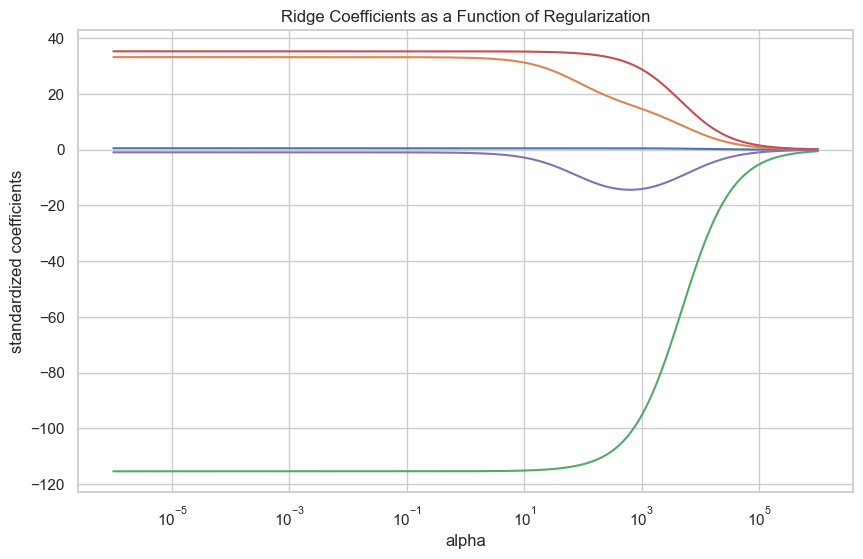

Coefficients for alpha=4:
 Unnamed: 0      0.505202
S              32.363473
K            -115.286297
tau            35.251592
r              -1.765051
dtype: float64

Best alpha using RidgeCV:  0.46595256686646774

Coefficients for best alpha:
 Unnamed: 0      0.505357
S              33.098739
K            -115.383878
tau            35.286389
r              -1.054251
dtype: float64
Coefficients for alpha=4:
 Unnamed: 0      0.505202
S              32.363473
K            -115.286297
tau            35.251592
r              -1.765051
dtype: float64

Coefficients for alpha=10^10:
 Unnamed: 0    4.849398e-07
S             9.315846e-06
K            -5.511288e-05
tau           1.597710e-05
r            -1.021896e-05
dtype: float64

Coefficients for alpha=0:
 Unnamed: 0      0.505379
S              33.200445
K            -115.396838
tau            35.291031
r              -0.955785
dtype: float64

Confirmed best alpha using RidgeCV:  5.672426068491977

Training score for Ridge model with best

In [78]:
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Load and prepare the training data again to ensure clarity
train_data = pd.read_csv("https://raw.githubusercontent.com/enosnas/BlackScholesOptionPricePredictionProject/main/option_train.csv")
X_train = train_data.drop(columns=['Value', 'BS'])  # Drop 'BS' and target column
y_train = train_data['Value']

# Load the test data correctly
test_data = pd.read_csv("https://raw.githubusercontent.com/enosnas/BlackScholesOptionPricePredictionProject/main/option_test_nolabel.csv")
X_test = test_data

# Standardizing the datasets
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

# Define a range of alphas
alphas = np.logspace(-6, 6, 200)

# Ridge regression to explore coefficient changes
ridge = Ridge()
coefs = []
for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(X_train_std, y_train)
    coefs.append(ridge.coef_)

# Plotting the coefficient shrinkage
plt.figure(figsize=(10, 6))
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('standardized coefficients')
plt.title('Ridge Coefficients as a Function of Regularization')
plt.show()

# Fit Ridge model with specific alpha values and display coefficients
ridge_specific = Ridge(alpha=4)
ridge_specific.fit(X_train_std, y_train)
print("Coefficients for alpha=4:\n", pd.Series(ridge_specific.coef_, index=X_train.columns))

# Using RidgeCV to find the best alpha and score the model
ridge_cv = RidgeCV(alphas=alphas, scoring='neg_mean_squared_error', cv=5)
ridge_cv.fit(X_train_std, y_train)
print("\nBest alpha using RidgeCV: ", ridge_cv.alpha_)

# Fit Ridge model with the best alpha from RidgeCV
ridge_best = Ridge(alpha=ridge_cv.alpha_)
ridge_best.fit(X_train_std, y_train)
print("\nCoefficients for best alpha:\n", pd.Series(ridge_best.coef_, index=X_train.columns))




# Ridge model with alpha=4
ridge2 = Ridge(alpha=4)
ridge2.fit(X_train_std, y_train)
pred2 = ridge2.predict(X_test_std)
print("Coefficients for alpha=4:\n", pd.Series(ridge2.coef_, index=X_train.columns))

# Ridge model with alpha=10^10 (demonstrates the effect of extremely high regularization)
ridge3 = Ridge(alpha=10**10)
ridge3.fit(X_train_std, y_train)
pred3 = ridge3.predict(X_test_std)
print("\nCoefficients for alpha=10^10:\n", pd.Series(ridge3.coef_, index=X_train.columns))

# Ridge model with alpha=0 (equivalent to ordinary least squares)
ridge4 = Ridge(alpha=0)
ridge4.fit(X_train_std, y_train)
pred4 = ridge4.predict(X_test_std)
print("\nCoefficients for alpha=0:\n", pd.Series(ridge4.coef_, index=X_train.columns))

# Reiterating RidgeCV to confirm the best alpha
ridge_cv_reiterated = RidgeCV(alphas=alphas, scoring='r2', cv=10)
ridge_cv_reiterated.fit(X_train_std, y_train)
print("\nConfirmed best alpha using RidgeCV: ", ridge_cv_reiterated.alpha_)

# Fit Ridge model with the best alpha from RidgeCV and score on training (as proxy, since we can't use test labels)
ridge5 = Ridge(alpha=ridge_cv_reiterated.alpha_)
ridge5.fit(X_train_std, y_train)
print("\nTraining score for Ridge model with best alpha: ", ridge5.score(X_train_std, y_train))


### End of Antares' Code

# Start of Eli's code


In [79]:
train_df = pd.read_csv("https://raw.githubusercontent.com/enosnas/BlackScholesOptionPricePredictionProject/main/option_train.csv")
test_df = pd.read_csv("https://raw.githubusercontent.com/enosnas/BlackScholesOptionPricePredictionProject/main/option_test_nolabel.csv")
train_df.dropna(inplace=True)
X = train_df[['S', 'K', 'r', 'tau']]
y = train_df['BS']
label_encoder = LabelEncoder()
y_encoder = label_encoder.fit_transform(y)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y_encoder, test_size=0.2, random_state=42)
k_values = range(1, 11)
best_accuracy = 0
best_k = None
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred_val = knn.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred_val)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_k = k
print('Best k:', best_k,)
print('Best k Accuracy:', accuracy)
knn_final = KNeighborsClassifier(n_neighbors=best_k)
knn_final.fit(X_scaled, y_encoder)
X_test = test_df[['S', 'K', 'r', 'tau']]
X_test_scaled = scaler.transform(X_test)
y_pred_test = knn_final.predict(X_test_scaled)
y_pred_test_original = label_encoder.inverse_transform(y_pred_test)
#print('predictions:', y_pred_test_original)


Best k: 6
Best k Accuracy: 0.908


### End of Eli's Code

# Naif's Code

In [80]:
# import training data
train_data = pd.read_csv("https://raw.githubusercontent.com/enosnas/BlackScholesOptionPricePredictionProject/main/option_train.csv")
print(train_data.head())
train_data.dtypes

   Unnamed: 0    Value        S     K       tau       r     BS
0           1  348.500  1394.46  1050  0.128767  0.0116  Under
1           2  149.375  1432.25  1400  0.679452  0.0113  Under
2           3  294.500  1478.90  1225  0.443836  0.0112  Under
3           4    3.375  1369.89  1500  0.117808  0.0119   Over
4           5   84.000  1366.42  1350  0.298630  0.0119  Under


Unnamed: 0      int64
Value         float64
S             float64
K               int64
tau           float64
r             float64
BS             object
dtype: object

In [81]:
# importe testing data
test_data = pd.read_csv("https://raw.githubusercontent.com/enosnas/BlackScholesOptionPricePredictionProject/main/option_test_nolabel.csv")
print(test_data.head())
test_data.dtypes

   Unnamed: 0        S     K       tau       r
0           1  1409.28  1325  0.126027  0.0115
1           2  1505.97  1100  0.315068  0.0110
2           3  1409.57  1450  0.197260  0.0116
3           4  1407.81  1250  0.101370  0.0116
4           5  1494.50  1300  0.194521  0.0110


Unnamed: 0      int64
S             float64
K               int64
tau           float64
r             float64
dtype: object

In [82]:
# describe training data
train_data.describe()

Unnamed: 0        Value            S            K          tau  \
count  5000.000000  5000.000000  5000.000000  5000.000000  5000.000000   
mean   2500.500000   140.316869  1426.643916  1370.244000     0.327615   
std    1443.520003   125.155000    56.051523   172.679107     0.231184   
min       1.000000     0.281250  1264.740000   750.000000     0.084932   
25%    1250.750000    45.750000  1387.670000  1275.000000     0.142466   
50%    2500.500000   105.125000  1434.320000  1400.000000     0.238356   
75%    3750.250000   200.406250  1469.440000  1475.000000     0.463014   
max    5000.000000   685.500000  1527.460000  1995.000000     0.989041   

                 r  
count  5000.000000  
mean      0.011468  
std       0.000448  
min       0.010600  
25%       0.011100  
50%       0.011400  
75%       0.011700  
max       0.012900

In [83]:
# checking for missing data
train_data.isna().sum()

Unnamed: 0    0
Value         0
S             0
K             0
tau           0
r             0
BS            0
dtype: int64

In [84]:
train_data.head()

Unnamed: 0    Value        S     K       tau       r     BS
0           1  348.500  1394.46  1050  0.128767  0.0116  Under
1           2  149.375  1432.25  1400  0.679452  0.0113  Under
2           3  294.500  1478.90  1225  0.443836  0.0112  Under
3           4    3.375  1369.89  1500  0.117808  0.0119   Over
4           5   84.000  1366.42  1350  0.298630  0.0119  Under

In [85]:
columns_to_clean = ['Value', 'S', 'K', 'tau', 'r']

# Function to clean data based on modified Z-score
def clean_data(df, column_name, threshold=3.5):
    median = np.median(df[column_name])
    mad = median_abs_deviation(df[column_name])
    z_scores = [0.6745 * (x - median) / mad if mad != 0 else 0 for x in df[column_name]]
    df = df.assign(**{f"{column_name}_z_score": z_scores})
    return df[df[f"{column_name}_z_score"].abs() <= threshold]

# Removing the 'Unnamed: 0' column and applying the cleaning function to each column
clean_train_df = train_data.drop('Unnamed: 0', axis=1).copy()
for column in columns_to_clean:
    clean_train_df = clean_data(clean_train_df, column)
    clean_train_df = clean_train_df.dropna()

# Drop the z-score columns after cleaning
clean_train_df = clean_train_df.drop([col + '_z_score' for col in columns_to_clean], axis=1)

clean_train_df.head()

Value        S     K       tau       r     BS
0  348.500  1394.46  1050  0.128767  0.0116  Under
1  149.375  1432.25  1400  0.679452  0.0113  Under
2  294.500  1478.90  1225  0.443836  0.0112  Under
3    3.375  1369.89  1500  0.117808  0.0119   Over
4   84.000  1366.42  1350  0.298630  0.0119  Under

In [86]:
clean_train_df.describe()

Value            S            K          tau            r
count  4704.000000  4704.000000  4704.000000  4704.000000  4704.000000
mean    128.741264  1426.533099  1379.355867     0.302658     0.011470
std     109.338283    56.103503   156.880978     0.204727     0.000448
min       0.281250  1264.740000   900.000000     0.084932     0.010600
25%      43.000000  1387.120000  1275.000000     0.139726     0.011100
50%      98.812500  1433.475000  1400.000000     0.219178     0.011400
75%     188.875000  1469.440000  1475.000000     0.428082     0.011700
max     466.000000  1527.460000  1900.000000     0.857534     0.012900

In [87]:
train_data.describe()

Unnamed: 0        Value            S            K          tau  \
count  5000.000000  5000.000000  5000.000000  5000.000000  5000.000000   
mean   2500.500000   140.316869  1426.643916  1370.244000     0.327615   
std    1443.520003   125.155000    56.051523   172.679107     0.231184   
min       1.000000     0.281250  1264.740000   750.000000     0.084932   
25%    1250.750000    45.750000  1387.670000  1275.000000     0.142466   
50%    2500.500000   105.125000  1434.320000  1400.000000     0.238356   
75%    3750.250000   200.406250  1469.440000  1475.000000     0.463014   
max    5000.000000   685.500000  1527.460000  1995.000000     0.989041   

                 r  
count  5000.000000  
mean      0.011468  
std       0.000448  
min       0.010600  
25%       0.011100  
50%       0.011400  
75%       0.011700  
max       0.012900

In [88]:
# Mapping 'BS' from 'Under' and 'Over' to 0 and 1
bs_mapping = {'Under': 0, 'Over': 1}
clean_train_df['BS'] = clean_train_df['BS'].map(bs_mapping)
clean_train_df.head()

Value        S     K       tau       r  BS
0  348.500  1394.46  1050  0.128767  0.0116   0
1  149.375  1432.25  1400  0.679452  0.0113   0
2  294.500  1478.90  1225  0.443836  0.0112   0
3    3.375  1369.89  1500  0.117808  0.0119   1
4   84.000  1366.42  1350  0.298630  0.0119   0

In [89]:
# Splitting the dataset into features and target variable using specified columns
X1 = clean_train_df[['S', 'K', 'r', 'tau']].values
y1 = clean_train_df['BS'].values

In [90]:
# Logistic Regression
X1 = clean_train_df[['S', 'K', 'r', 'tau']].values
y1 = clean_train_df['BS'].values
# Splitting the data
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.30, random_state=42)

# Creating and training the logistic regression model
logistic_model_1 = LogisticRegression(max_iter=1000)  # Increased max_iter for convergence
logistic_model_1.fit(X1_train, y1_train)

# Predicting the BS values on the testing data
y1_pred = logistic_model_1.predict(X1_test)

# Calculating the classification error for Logistic Regression
classification_error_logistic = 1 - accuracy_score(y1_test, y1_pred)
print("Classification Error for Logistic Regression:", classification_error_logistic)

# evaluation metrics
print("Confusion Matrix:\n", confusion_matrix(y1_test, y1_pred))
print("Classification Report:\n", classification_report(y1_test, y1_pred))
print("ROC AUC Score:", roc_auc_score(y1_test, logistic_model_1.predict_proba(X1_test)[:, 1]))

# Performing 10-fold cross-validation on the Logistic Regression model
cv_scores_logistic = cross_val_score(logistic_model_1, X1, y1, cv=10, scoring='accuracy')

# Calculating the mean classification error across all folds for Logistic Regression
classification_error_logistic_cv = 1 - np.mean(cv_scores_logistic)
print("Mean Classification Error with CV (Logistic Regression):", classification_error_logistic_cv)
print("Cross-validation Accuracy Scores (Logistic Regression):", cv_scores_logistic)

Classification Error for Logistic Regression: 0.10977337110481589
Confusion Matrix:
 [[1020   65]
 [  90  237]]
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.94      0.93      1085
           1       0.78      0.72      0.75       327

    accuracy                           0.89      1412
   macro avg       0.85      0.83      0.84      1412
weighted avg       0.89      0.89      0.89      1412

ROC AUC Score: 0.9404783043729478
Mean Classification Error with CV (Logistic Regression): 0.11416045534625285
Cross-validation Accuracy Scores (Logistic Regression): [0.89384289 0.88747346 0.87685775 0.89596603 0.86808511 0.87234043
 0.88510638 0.89148936 0.89574468 0.89148936]


In [91]:
# KNN
X1 = clean_train_df[['S', 'K', 'r', 'tau']].values
y1 = clean_train_df['BS'].values
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.30, random_state=42)

# Creating the KNN model with k=5
knn_model = KNeighborsClassifier(n_neighbors=5)

# Training the KNN model
knn_model.fit(X_train, y_train)

# Predicting the BS values on the testing data
y_pred_knn = knn_model.predict(X_test)
y_pred_proba_knn = knn_model.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class

# Calculate classification error
classification_error_knn = 1 - accuracy_score(y_test, y_pred_knn)
print("Classification Error for KNN:", classification_error_knn)

# evaluation metrics
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_knn))
print("Classification Report:\n", classification_report(y_test, y_pred_knn))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_proba_knn))  # ROC AUC computation

# perform cross-validation
cv_scores_knn = cross_val_score(knn_model, X1, y1, cv=10, scoring='accuracy')
classification_error_knn_cv = 1 - np.mean(cv_scores_knn)
print("Mean Classification Error with CV (KNN):", classification_error_knn_cv)
print("Cross-validation Accuracy Scores (KNN):", cv_scores_knn)


Classification Error for KNN: 0.15084985835694054
Confusion Matrix:
 [[957 128]
 [ 85 242]]
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.88      0.90      1085
           1       0.65      0.74      0.69       327

    accuracy                           0.85      1412
   macro avg       0.79      0.81      0.80      1412
weighted avg       0.86      0.85      0.85      1412

ROC AUC Score: 0.8969588071985231
Mean Classification Error with CV (KNN): 0.13945430726837427
Cross-validation Accuracy Scores (KNN): [0.84501062 0.88535032 0.85138004 0.85350318 0.85319149 0.85531915
 0.86382979 0.85957447 0.86382979 0.87446809]


In [92]:
# SVM
X1 = clean_train_df[['S', 'K', 'r', 'tau']].values
y1 = clean_train_df['BS'].values
# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.30, random_state=42)

# Creating the SVM model with an RBF kernel
svm_rbf = SVC(kernel='rbf', random_state=42, probability=True)

# Training the SVM model
svm_rbf.fit(X_train, y_train)

# Predicting the BS values on the testing data
y_pred_rbf = svm_rbf.predict(X_test)

# Calculating the classification error for SVM with RBF kernel
classification_error_rbf = 1 - accuracy_score(y_test, y_pred_rbf)
print("Classification Error for SVM (RBF):", classification_error_rbf)

# evaluation metrics
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rbf))
print("Classification Report:\n", classification_report(y_test, y_pred_rbf))
print("ROC AUC Score:", roc_auc_score(y_test, svm_rbf.predict_proba(X_test)[:, 1]))

# Performing 10-fold cross-validation on the SVM model with RBF kernel
cv_scores_rbf = cross_val_score(svm_rbf, X1, y1, cv=10, scoring='accuracy')

# Calculating the mean classification error across all folds for SVM with RBF kernel
classification_error_rbf_cv = 1 - np.mean(cv_scores_rbf)
print("Mean Classification Error with CV (SVM RBF):", classification_error_rbf_cv)
print("Cross-validation Accuracy Scores (SVM RBF):", cv_scores_rbf)

Classification Error for SVM (RBF): 0.15368271954674217
Confusion Matrix:
 [[1026   59]
 [ 158  169]]
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.95      0.90      1085
           1       0.74      0.52      0.61       327

    accuracy                           0.85      1412
   macro avg       0.80      0.73      0.76      1412
weighted avg       0.84      0.85      0.84      1412

ROC AUC Score: 0.9024591665609718
Mean Classification Error with CV (SVM RBF): 0.15519447079550075
Cross-validation Accuracy Scores (SVM RBF): [0.82590234 0.86199575 0.86624204 0.85987261 0.82340426 0.83191489
 0.83404255 0.84255319 0.86382979 0.83829787]


In [93]:
X1 = clean_train_df[['S', 'K', 'r', 'tau']].values
y1 = clean_train_df['BS'].values
# Extracting features and target from train_data
X1 = train_data[['S', 'K', 'r', 'tau']].values
y1 = train_data['BS'].values

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.30, random_state=42)

# Creating the Random Forest model
random_forest = RandomForestClassifier(n_estimators=50, random_state=42)

# Training the Random Forest model
random_forest.fit(X_train, y_train)

# Predicting the BS values on the testing data
y_pred_rf = random_forest.predict(X_test)

# Evaluation using Accuracy, Confusion Matrix, and Classification Report
print("Classification Error for Random Forest:", 1 - accuracy_score(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))
print("ROC AUC Score:", roc_auc_score(y_test, random_forest.predict_proba(X_test)[:, 1]))

# Performing 10-fold cross-validation on the Random Forest model
cv_scores_rf = cross_val_score(random_forest, X1, y1, cv=10, scoring='accuracy')

# Calculating the mean classification error across all folds for Random Forest
print("Mean Classification Error with CV (Random Forest):", 1 - np.mean(cv_scores_rf))
print("Cross-validation Accuracy Scores (Random Forest):", cv_scores_rf)

Classification Error for Random Forest: 0.06399999999999995
Confusion Matrix:
 [[ 288   54]
 [  42 1116]]
Classification Report:
               precision    recall  f1-score   support

        Over       0.87      0.84      0.86       342
       Under       0.95      0.96      0.96      1158

    accuracy                           0.94      1500
   macro avg       0.91      0.90      0.91      1500
weighted avg       0.94      0.94      0.94      1500

ROC AUC Score: 0.9687793533921158
Mean Classification Error with CV (Random Forest): 0.06220000000000003
Cross-validation Accuracy Scores (Random Forest): [0.928 0.93  0.934 0.944 0.924 0.94  0.942 0.942 0.944 0.95 ]


In [94]:
# LDA
X1 = clean_train_df[['S', 'K', 'r', 'tau']].values
y1 = clean_train_df['BS'].values
# Splitting the data
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.30, random_state=42)

# Creating the LDA model
lda_model = LinearDiscriminantAnalysis()

# Training the LDA model
lda_model.fit(X1_train, y1_train)

# Predicting the BS values on the testing data
y1_pred_lda = lda_model.predict(X1_test)

# Calculating the classification error for LDA
classification_error_lda = 1 - accuracy_score(y1_test, y1_pred_lda)
print("Classification Error for LDA:", classification_error_lda)

# evaluation metrics
print("Confusion Matrix:\n", confusion_matrix(y1_test, y1_pred_lda))
print("Classification Report:\n", classification_report(y1_test, y1_pred_lda))
print("ROC AUC Score:", roc_auc_score(y1_test, lda_model.predict_proba(X1_test)[:, 1]))

# Performing 10-fold cross-validation on the LDA model
cv_scores_lda = cross_val_score(lda_model, X1, y1, cv=10, scoring='accuracy')

# Calculating the mean classification error across all folds for LDA
classification_error_lda_cv = 1 - np.mean(cv_scores_lda)
print("Mean Classification Error with CV (LDA):", classification_error_lda_cv)
print("Cross-validation Accuracy Scores (LDA):", cv_scores_lda)

Classification Error for LDA: 0.11614730878186974
Confusion Matrix:
 [[1037   48]
 [ 116  211]]
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.96      0.93      1085
           1       0.81      0.65      0.72       327

    accuracy                           0.88      1412
   macro avg       0.86      0.80      0.82      1412
weighted avg       0.88      0.88      0.88      1412

ROC AUC Score: 0.9382911258614128
Mean Classification Error with CV (LDA): 0.1256434927948682
Cross-validation Accuracy Scores (LDA): [0.88535032 0.88322718 0.88322718 0.87261146 0.85319149 0.86595745
 0.86595745 0.86382979 0.88723404 0.88297872]


In [95]:
# XGBoost
X1 = clean_train_df[['S', 'K', 'r', 'tau']].values
y1 = clean_train_df['BS'].values
# Split your data
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.30, random_state=42)

# Initialize and train XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

# Predict on the test set
y_pred_xgb = xgb_model.predict(X_test)

# Calculate classification error
classification_error_xgb = 1 - accuracy_score(y_test, y_pred_xgb)
print("Classification Error for XGBoost:", classification_error_xgb)

# evaluation metrics
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))
print("Classification Report:\n", classification_report(y_test, y_pred_xgb))
print("ROC AUC Score:", roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:, 1]))

# perform cross-validation
cv_scores_xgb = cross_val_score(xgb_model, X1, y1, cv=10, scoring='accuracy')
classification_error_xgb_cv = 1 - np.mean(cv_scores_xgb)
print("Mean Classification Error with CV (XGBoost):", classification_error_xgb_cv)
print("Cross-validation Accuracy Scores (XGBoost):", cv_scores_xgb)


Classification Error for XGBoost: 0.06798866855524077
Confusion Matrix:
 [[1031   54]
 [  42  285]]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.95      0.96      1085
           1       0.84      0.87      0.86       327

    accuracy                           0.93      1412
   macro avg       0.90      0.91      0.91      1412
weighted avg       0.93      0.93      0.93      1412

ROC AUC Score: 0.9742809227863978
Mean Classification Error with CV (XGBoost): 0.062288024574242096
Cross-validation Accuracy Scores (XGBoost): [0.95329087 0.94267516 0.92356688 0.93418259 0.93404255 0.92340426
 0.93829787 0.93829787 0.94255319 0.94680851]


In [96]:
# DT
X1 = clean_train_df[['S', 'K', 'r', 'tau']].values
y1 = clean_train_df['BS'].values
# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.30, random_state=42)

# Creating the Decision Tree model
decision_tree = DecisionTreeClassifier(random_state=42)

# Training the Decision Tree model
decision_tree.fit(X_train, y_train)

# Predicting the BS values on the testing data
y_pred_dt = decision_tree.predict(X_test)

# Evaluation using Accuracy, Confusion Matrix, and Classification Report
print("Classification Error for Decision Tree:", 1 - accuracy_score(y_test, y_pred_dt))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_dt))
print("Classification Report:\n", classification_report(y_test, y_pred_dt))

# ROC AUC Score (only if decision_tree has predict_proba enabled and it makes sense to calculate it)
if hasattr(decision_tree, "predict_proba"):
    roc_auc_dt = roc_auc_score(y_test, decision_tree.predict_proba(X_test)[:, 1])
    print("ROC AUC Score:", roc_auc_dt)

# Performing 10-fold cross-validation on the Decision Tree model
cv_scores_dt = cross_val_score(decision_tree, X1, y1, cv=10, scoring='accuracy')

# Calculating the mean classification error across all folds for Decision Tree
print("Mean Classification Error with CV (Decision Tree):", 1 - np.mean(cv_scores_dt))
print("Cross-validation Accuracy Scores (Decision Tree):", cv_scores_dt)

Classification Error for Decision Tree: 0.09419263456090654
Confusion Matrix:
 [[1012   73]
 [  60  267]]
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.93      0.94      1085
           1       0.79      0.82      0.80       327

    accuracy                           0.91      1412
   macro avg       0.86      0.87      0.87      1412
weighted avg       0.91      0.91      0.91      1412

ROC AUC Score: 0.8746163277385532
Mean Classification Error with CV (Decision Tree): 0.08482495369742948
Cross-validation Accuracy Scores (Decision Tree): [0.91295117 0.92569002 0.91082803 0.92781316 0.90212766 0.9106383
 0.91489362 0.90425532 0.92340426 0.91914894]


In [97]:
X1 = clean_train_df[['S', 'K', 'r', 'tau']].values
y1 = clean_train_df['BS'].values

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.30, random_state=42)

# Creating the LightGBM model
lgbm_model = lgb.LGBMClassifier(boosting_type='gbdt', objective='binary', random_state=42)

# Training the LightGBM model
lgbm_model.fit(X_train, y_train, eval_metric='logloss')

# Predicting the BS values on the testing data
y_pred_lgbm = lgbm_model.predict(X_test)

# Evaluation using Accuracy, Confusion Matrix, and Classification Report
classification_error_lgbm = 1 - accuracy_score(y_test, y_pred_lgbm)
print("Classification Error for LightGBM:", classification_error_lgbm)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lgbm))
print("Classification Report:\n", classification_report(y_test, y_pred_lgbm))
print("ROC AUC Score:", roc_auc_score(y_test, lgbm_model.predict_proba(X_test)[:, 1]))

# Performing 10-fold cross-validation on the LightGBM model
cv_scores_lgbm = cross_val_score(lgbm_model, X1, y1, cv=10, scoring='accuracy')

# Calculating the mean classification error across all folds for LightGBM
mean_classification_error_lgbm_cv = 1 - np.mean(cv_scores_lgbm)
print("Mean Classification Error with CV (LightGBM):", mean_classification_error_lgbm_cv)
print("Cross-validation Accuracy Scores (LightGBM):", cv_scores_lgbm)

[LightGBM] [Info] Number of positive: 793, number of negative: 2499
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000102 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 530
[LightGBM] [Info] Number of data points in the train set: 3292, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.240887 -> initscore=-1.147823
[LightGBM] [Info] Start training from score -1.147823
Classification Error for LightGBM: 0.07223796033994334
Confusion Matrix:
 [[1024   61]
 [  41  286]]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.94      0.95      1085
           1       0.82      0.87      0.85       327

    accuracy                           0.93      1412
   macro avg       0.89      0.91      0.90      1412
weighted avg       0.93      0.93      0.93      1412

ROC AUC Score: 0.9739666568018152
[LightGBM] [Info] Number o

### End of Naif's code